In [3]:
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage import io
from skimage import measure
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
import json
from skimage.filters import threshold_multiotsu
from skimage.transform import rescale, resize, downscale_local_mean

In [4]:
# deconvolution file generated by STRIDE
sample = "KC2"
deconv_dir = "/data/Tools/STRIDE/STRIDE/Result/our_results/"
deconv_file = f"{deconv_dir}our_results_{sample}_spot_celltype_frac.txt"
deconv_df = pd.read_csv(deconv_file, sep = "\t", index_col = 0)

# spot location file generated by Spaceranger
st_loc_file = f"/data/Datasets/Annotated/TLS_VISIUM/10x_Visium/{sample}/spatial/tissue_positions_list.csv"
st_df = pd.read_csv(st_loc_file, index_col = 0)

# scale factor file generated by Spaceranger
rescale_factor_dict = json.load(open(f"/data/Datasets/Annotated/TLS_VISIUM/10x_Visium/{sample}/spatial/scalefactors_json.json", "r"))
rescale_factor = rescale_factor_dict['tissue_hires_scalef']

# H&E image
img = io.imread(f"/data/Datasets/Annotated/TLS_VISIUM/10x_Visium/{sample}/spatial/tissue_hires_image.png")
img_sub = img

# tls output file
out_dir = "/data/Tools/STRIDE/STRIDE/Result/our_results/spacescanner"
tls_loc_file = os.path.join(out_dir, "%s_TLS_loc_label.txt" % sample)

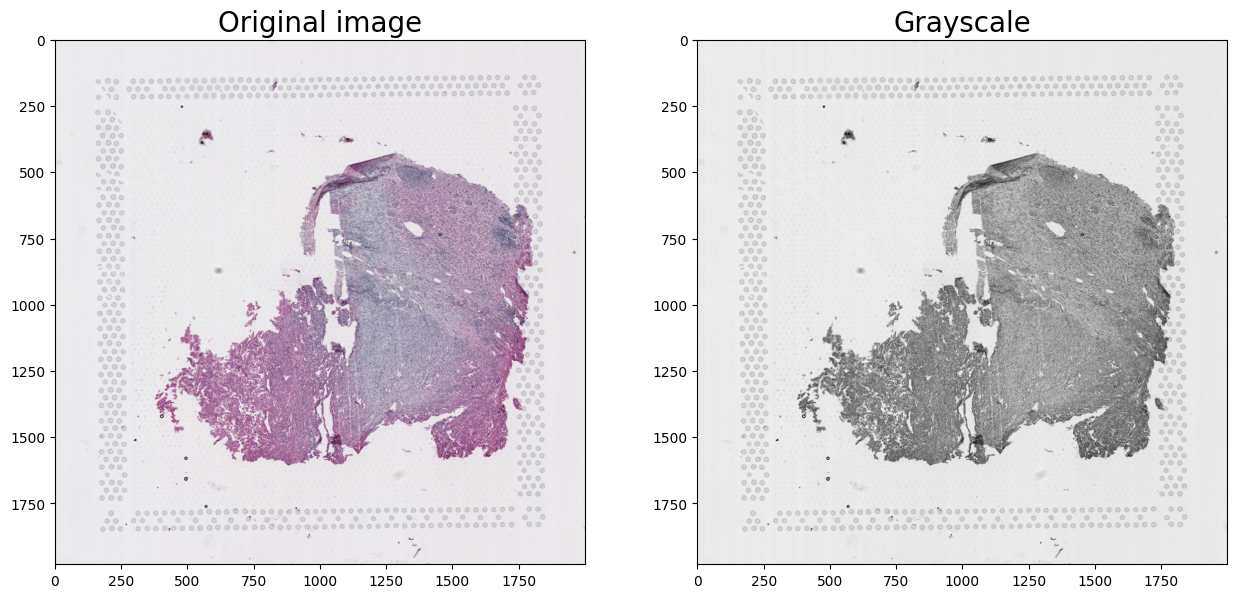

In [5]:
# convert original image to grayscale
lum = color.rgb2gray(img_sub)
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax1, ax2 = ax.ravel()
ax1.imshow(img_sub)
ax1.set_title("Original image", fontsize=20)
ax2.imshow(lum, cmap="gray")
ax2.set_title("Grayscale", fontsize=20)
plt.tight_layout()
plt.show()

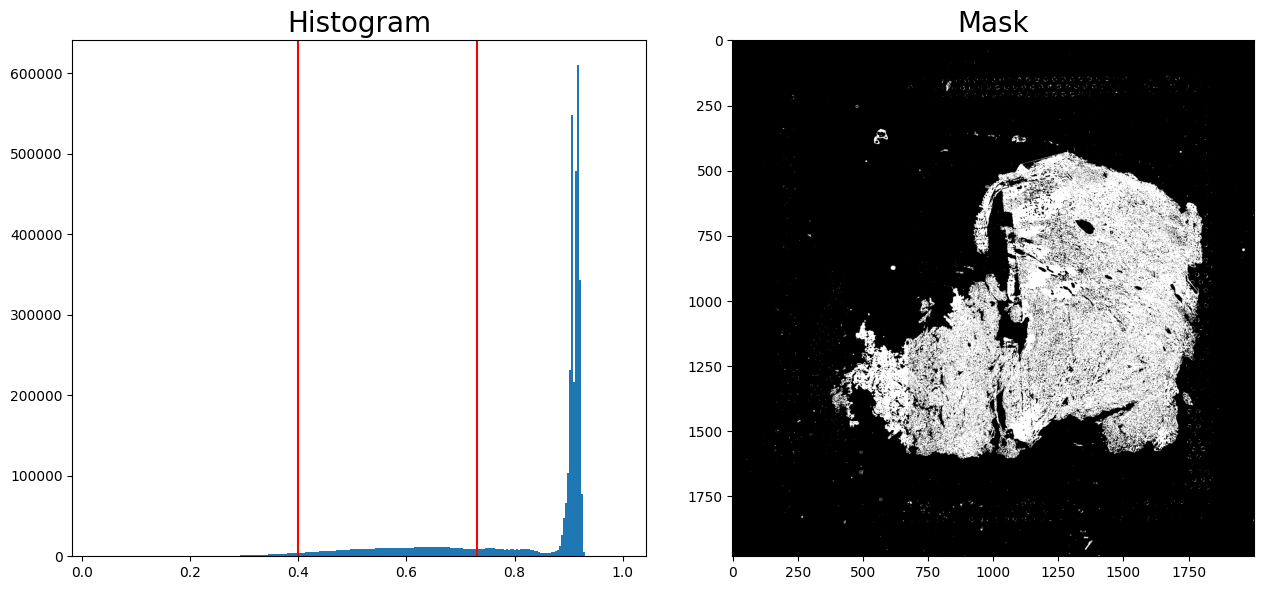

In [6]:
# Compute a mask
thresholds_mult = threshold_multiotsu(lum)
thre_low = 0.4
thre_high = 0.73
thresholds = [thre_low, thre_high]
mask = np.logical_and(lum > thre_low, lum < thre_high)

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax1, ax2 = ax.ravel()
ax1.hist(lum.ravel(), bins=255)
for thresh in thresholds:
    ax1.axvline(thresh, color='r')
ax1.set_title('Histogram', fontsize=20)
ax2.imshow(mask, cmap="gray")
ax2.set_title('Mask', fontsize=20)
plt.tight_layout()
plt.show()

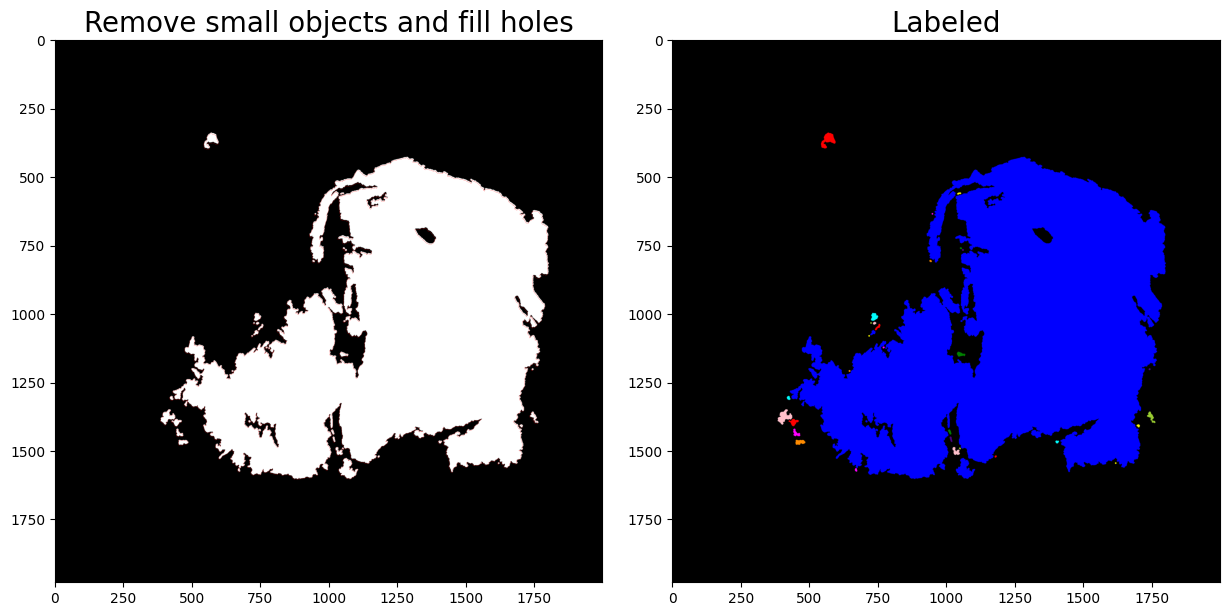

In [7]:
# mask = morphology.closing(mask, morphology.disk(3))
# Remove small objects and Fill holes
mask_filled = morphology.remove_small_holes(
    morphology.remove_small_objects(mask, 500),
    800)  
mask_filled = morphology.opening(mask_filled, morphology.disk(3))
# mask_filled = morphology.erosion(mask_filled, morphology.disk(5))
mask_filled_label = measure.label(mask_filled, connectivity = 2)

fig, ax = plt.subplots(1, 2, figsize=(12.5, 6))
ax1, ax2 = ax.ravel()
ax1.imshow(mask_filled, cmap="gray")
ax1.contour(mask_filled, colors='r', linewidths=0.1)
ax1.set_title("Remove small objects and fill holes", fontsize=20)
ax2.imshow(color.label2rgb(mask_filled_label, bg_label=0))
ax2.set_title("Labeled", fontsize=20)
plt.tight_layout()
plt.show()

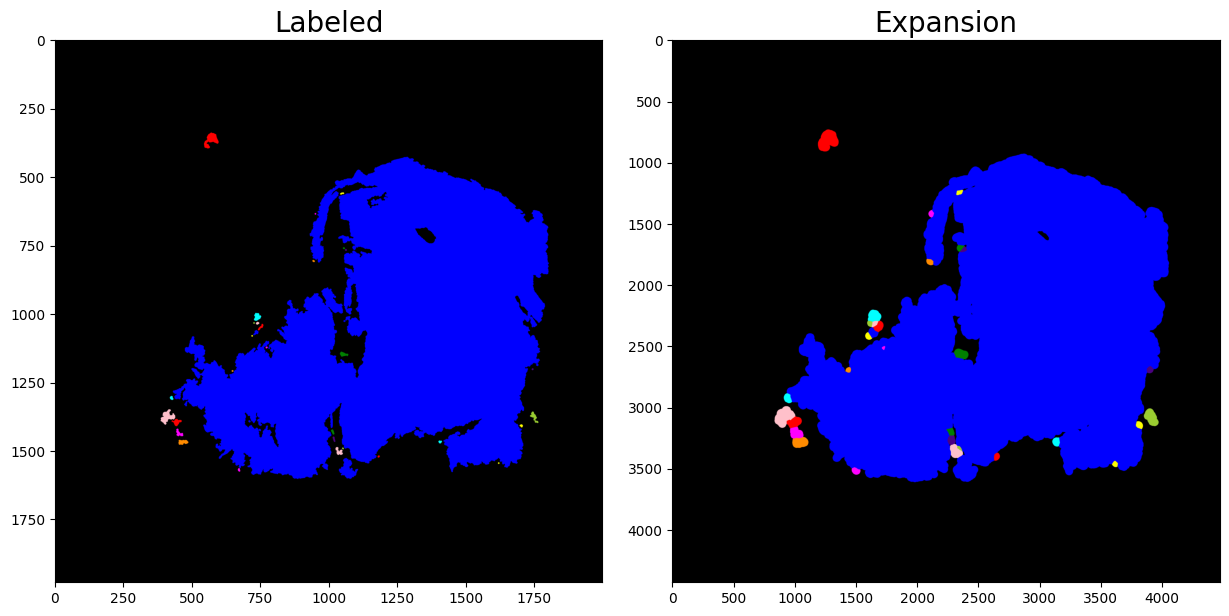

In [8]:
# scale and expand
mask_filled_scaled = rescale(mask_filled, 1/rescale_factor, anti_aliasing=False)
mask_filled_scaled_label = measure.label(mask_filled_scaled)
mask_filled_scaled_label_expanded = segmentation.expand_labels(mask_filled_scaled_label, distance=25)

fig, ax = plt.subplots(1, 2, figsize=(12.5, 6))
ax1, ax2 = ax.ravel()
ax1.imshow(color.label2rgb(mask_filled_label, bg_label=0))
ax1.set_title("Labeled", fontsize=20)
ax2.imshow(color.label2rgb(mask_filled_scaled_label_expanded, bg_label=0))
ax2.set_title("Expansion", fontsize=20)
plt.tight_layout()
plt.show()

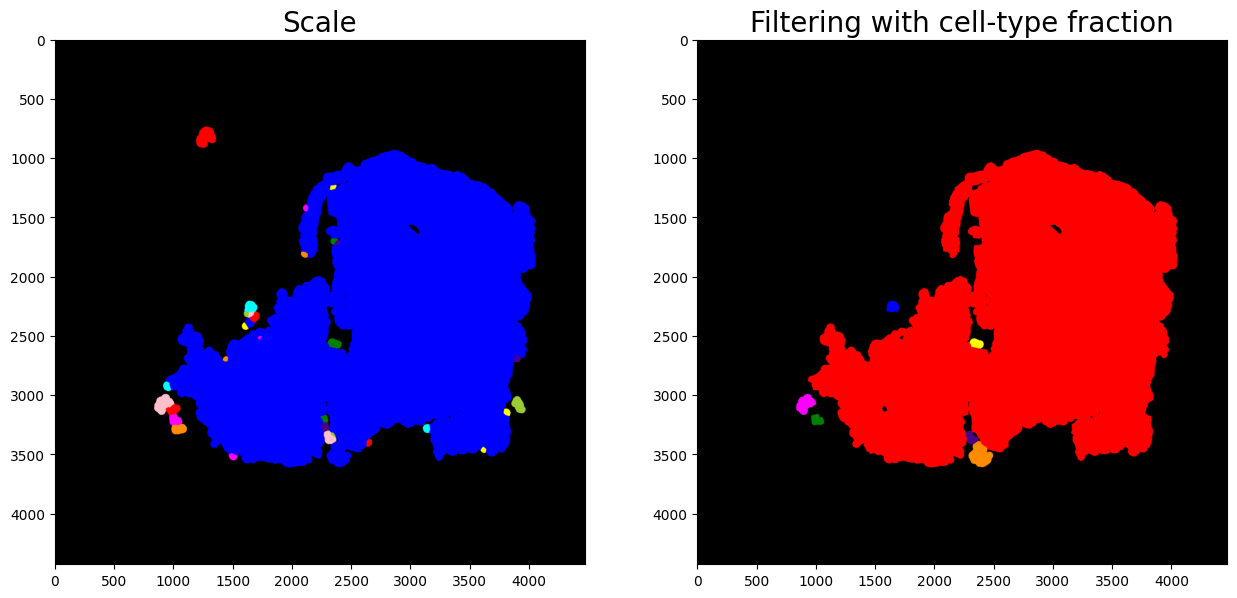

In [28]:
# combine deconvolution results 
st_df = st_df.rename(columns={
    'pxl_row_in_fullres': 'X', 
    'pxl_col_in_fullres': 'Y'
})
st_df_filtered = st_df.loc[common_indices]
st_df_filtered['Label'] = [mask_filled_scaled_label_expanded[st_df_filtered.loc[i, "X"], st_df_filtered.loc[i, "Y"]] for i in st_df_filtered.index]
st_df_filtered['B'] = deconv_df.loc[st_df_filtered.index, 'B']
st_df_filtered['CD8 T'] = deconv_df.loc[st_df_filtered.index, 'CD8 T']
st_df_filtered['CD4 T'] = deconv_df.loc[st_df_filtered.index, 'Naive CD4 T']
st_df_filtered['Lymphocyte'] = deconv_df[['B', 'Naive CD4 T', 'CD8 T']].sum(axis = 1)
label_mean_df = st_df_filtered.groupby('Label').mean()
label_count_df = st_df_filtered.groupby('Label').count()
tls_label = label_mean_df.index[np.logical_and(np.logical_and(label_mean_df['Lymphocyte'] > 0.15, 
                                               label_count_df['Lymphocyte'] > 1), 
                                              label_mean_df['B'] > 0.1)]
mask_filled_scaled_tls = mask_filled_scaled_label_expanded.copy()
mask_filled_scaled_tls[np.isin(mask_filled_scaled_tls, tls_label, invert=True)] = 0

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax1, ax2 = ax.ravel()
ax1.imshow(color.label2rgb(mask_filled_scaled_label_expanded, bg_label=0))
ax1.set_title("Scale", fontsize=20)
ax2.imshow(color.label2rgb(mask_filled_scaled_tls, bg_label=0))
ax2.set_title("Filtering with cell-type fraction", fontsize=20)
plt.tight_layout()
plt.show()